RandomForestClassifier F1 Score: 0.9967532467532467


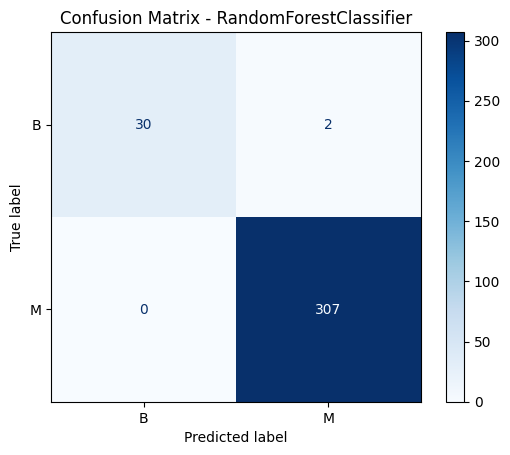

XGBClassifier F1 Score: 0.9951219512195122


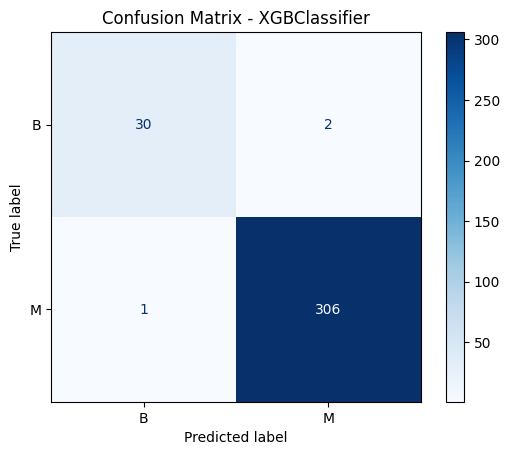

Tuned RandomForestClassifier F1 Score: 0.9967532467532467


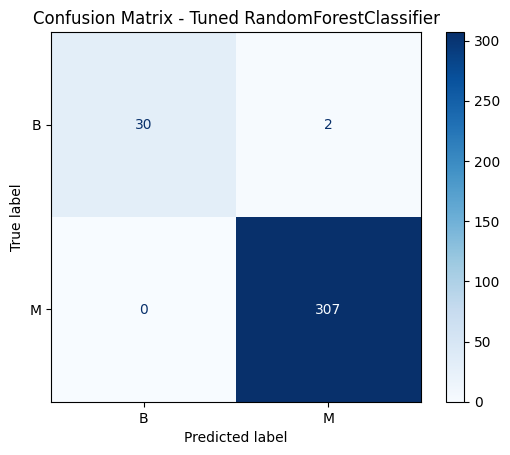

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

def load_data(filepath):
    """Load data from CSV file."""
    df = pd.read_csv(filepath, index_col=0)
    return df.dropna(axis=0)

def encode_labels(df):
    """Encode labels using LabelEncoder."""
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    return df

def create_feature_hasher(df):
    """Create hashed features using FeatureHasher."""
    hashed_features = []
    hasher = FeatureHasher(n_features=1000, input_type='string')
    for lst in df['function_dll']:
        hashed_features.append(hasher.fit_transform([lst]).toarray().flatten().astype(np.float32).tolist())
    hashed_df = pd.DataFrame(hashed_features)
    return hashed_df

def group_data_by_hash(df):
    """Collect functions and dlls by SHA256 hash."""
    return df.groupby('SHA256').agg({'label': 'first', 'function_dll': lambda x: [str(i) for i in x]}).reset_index()

def preprocess_data(df):
    """Preprocess data: encode labels and create hashed features."""
    df['function_dll'] = df['function_name'] + '_' + df['dll']
    df = encode_labels(df)
    df= group_data_by_hash(df)
    hashed_df = create_feature_hasher(df)
    result_df = pd.concat([df[['SHA256', 'label']], hashed_df], axis=1)
    result_df.columns = ['SHA256', 'label'] + [f'feature_{i}' for i in range(1000)]
    return result_df

def train_model(model, X_train, y_train):
    """Train the specified model."""
    model.fit(X_train, y_train)

def plot_confusion_matrix(model, X_test, y_test, model_name):
    """Plot confusion matrix for the specified model."""
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    
    # Specify display labels
    display_labels = ['B', 'M']
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

def evaluate_models(models, X_train, X_test, y_train, y_test):
    """Evaluate models based on F1 score."""
    model_f1_scores = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        f1 = f1_score(y_test, predictions)
        model_f1_scores[model_name] = f1
        print(f"{model_name} F1 Score: {f1}")
        # Plot confusion matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
    return model_f1_scores

def tune_hyperparameters(model, param_grid, X_train, y_train, X_test, y_test):
    """Tune hyperparameters for the specified model."""
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
    grid_search.fit(X_train, y_train)
    best_hyperparameters = grid_search.best_params_
    best_model_tuned = grid_search.best_estimator_
    predictions_tuned = best_model_tuned.predict(X_test)
    f1_tuned = f1_score(y_test, predictions_tuned)
    print(f"Tuned {model.__class__.__name__} F1 Score: {f1_tuned}")
    plot_confusion_matrix(best_model_tuned, X_test, y_test, f"Tuned {model.__class__.__name__}")
    return best_model_tuned

def calculate_scale_pos_ratio(y_train):
    """Calculate scale_pos_weight ratio."""
    class_counts = y_train.value_counts()
    return class_counts[0] / class_counts[1]
# Load data
filepath = "16_Ransomware_Detection_Using_PE_Imports.csv"
df = load_data(filepath)

# Preprocess data
result_df = preprocess_data(df)

# Split data into train and test sets
X = result_df.drop(['SHA256', 'label'], axis=1)
y = result_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize models
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42,scale_pos_weight=calculate_scale_pos_ratio(y_train)),
}

# Evaluate models
model_f1_scores = evaluate_models(models, X_train, X_test, y_train, y_test)

# Tune hyperparameters for the best performing model
best_model_name = max(model_f1_scores, key=model_f1_scores.get)
best_model = models[best_model_name]

# Define hyperparameters grid for the selected model
param_grid = {
    'n_estimators': [50, 100, 150,200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Tune hyperparameters
best_model_tuned = tune_hyperparameters(best_model, param_grid, X_train, y_train, X_test, y_test)

In [14]:
import joblib

# Save the best model
joblib.dump(best_model_tuned, 'best_model_rf.pkl')

['best_model_rf.pkl']